# 4. Basic file management, Programming options

- Basic file management
   - **4.1** Creating files
   - **4.2** Merging files

- Programming  
   - **4.3** Adding options
   - **4.4** Postfile in a program

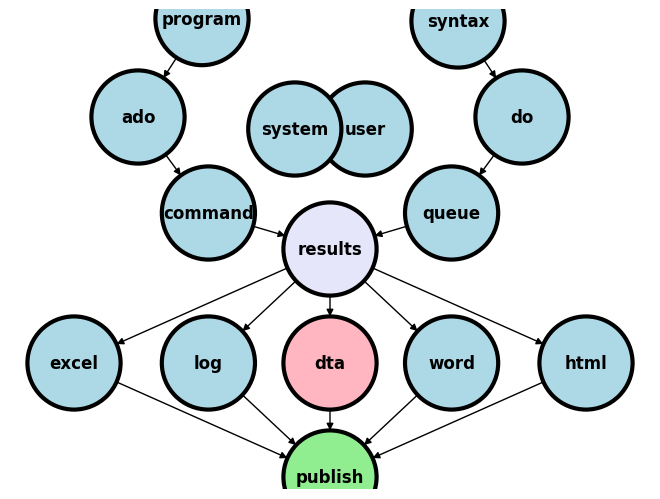

In [1]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()
G.add_node("user", pos=(550, 500))
G.add_node("system", pos=(-550, 500))
G.add_node("program", pos=(-2000, 960))
G.add_node("syntax", pos=(2000, 950))
G.add_node("ado", pos=(-3000, 550))
G.add_node("do", pos=(3000, 550))
G.add_node("command", pos=(-1900, 150))
G.add_node("queue", pos=(1900, 150))
G.add_node("results", pos=(0, 0))
G.add_node("dta", pos=(0, -475))
G.add_node("log", pos=(-1900, -475))
G.add_node("excel", pos=(-4000, -475))
G.add_node("word", pos=(1900, -475))
G.add_node("html", pos=(4000, -475))
G.add_node("publish", pos=(0, -950))
G.add_edges_from([("program", "ado"), ("syntax", "do")])
G.add_edges_from([("ado", "command"), ("do", "queue")])
G.add_edges_from([("command", "results"), ("queue", "results"), ("results", "excel"), ("results", "word"), ("results", "html")])
G.add_edges_from([("results", "dta"), ("results", "log")])
G.add_edges_from([("dta", "publish"), ("log", "publish"), ("excel", "publish"), ("word", "publish"), ("html", "publish")])

pos = nx.get_node_attributes(G, 'pos')
node_colors = ["lightblue" if node not in ["results", "dta", "publish"] else "lightpink" if node == "dta" else "lavender" if node == "results" else "lightgreen" for node in G.nodes()]

nx.draw(G, pos, with_labels=True, font_weight='bold', node_size=4500, node_color=node_colors, linewidths=3)
ax = plt.gca()
ax.collections[0].set_edgecolor("#000000")  # Set edge color to black for better contrast
ax.set_xlim([-5000, 5000])
ax.set_ylim([-1000, 1000])
plt.show()

## 4.1 Creating files

During our second week had a cursory discussion about the basic files we may output our results into:

- `.xlsx`
- `.log`
- `.dta`
- `.docx`
- `.html`

In the **Intermediate** class we've focused mostly on `.html`, since we're creating websites to host our content online. In this **Basic** class we've directed our energies at `.xlsx` and `.log`, as seen in HW3, which is due today. Its time to revist `.dta`, which perhaps we didn't have time to develop in week two. Here's a [link](https://jhustata.github.io/basic/chapter2.html#dta) to the section of the week to session in which we covered it, with explanatory notes. 

<Details>
   <Summary>Review of Data Posting and Analysis in Stata</Summary>

```stata
* Clear the previous data and results to ensure a clean workspace.
clear all
cls

* Set up a postfile to store data. This command creates a dataset called output.dta.
* 'a' is a string variable with a maximum length of 80 characters.
* 'b' and 'c' are numeric variables stored as floats.
postfile pp str80 a float(b c) using output.dta, replace

* Post data into the postfile. Each 'post' command adds one observation with three fields.
* 'a' is used as a categorical identifier.
* 'b' and 'c' are quantitative measurements, likely representing some continuous data.
post pp ("1") (24.4) (123)
post pp ("2") (31.5) (164)
post pp ("3") (29.0) (118)

* Close the postfile to finalize changes and prepare the dataset for analysis.
postclose pp

* Load the newly created dataset into memory for further operations.
use output.dta, clear 

* List all observations to verify data integrity and correct input.
list

* Provide a descriptive summary of the dataset, including information on each variable.
describe
```
</Details>


We are now in position to apply `postfile` this to a meaningful example using what we've learned so far:
- Variable-type specifiers
- A `foreach` loop
- Storage of `r()` values in `local` macros

#### `postfile` to post regression results

```stata
postfile pp str80 coef ///
   double(result CIleft CIright pvalue) /// 
   using betas.dta, replace
```

-  Within the script, call our post "pp"
- It will have five variables: a string called coef and [doubles](https://jhustata.github.io/basic/chapter1.html#variable-types)
(floating-point decimals) called `result`, `CIleft`, etc
- The file name on disk will be `betas.dta`
- If `betas.dta` exists, replace it

```stata
regress bmi gender age
foreach v of varlist gender age {
    //[calculate beta, etc into macros] 
    post pp ("`v'") (`res') (`left') ///
    (`right') (`pvals')
}
```

<Details>
   <Summary></Summary>

   ```stata
   foreach v of varlist gender age {
        //[calculate beta, etc into macros] 
	    local vlab: variable label `v'
	    lincom "`v'" //estimate r() values one variable at a time
	    local res: di %3.2f r(estimate)
	    local left: di %3.2f r(lb)
	    local right: di %3.2f r(ub)
	    local pvals: di %3.2f r(p)
        post pp ("`vlab'") (`res') (`left') ///
            (`right') (`pvals')
}

   ```

   We may use the created `betas.dta` to visualize our regression output:

   ```stata
use betas, clear 
encode coef, gen(Coef)
twoway (scatter result Coef) ///
       (rcap CIleft CIright Coef, ///
           xlab(0(1)3 0 " " 1 "Age" 2 "Gender" 3 " ") ///
		   xti("Predictors") ///
		   ti("Increase in BMI per unit increase in predictor ") ///
		   legend(off) ///
		   yline(0, lc(lime) lp(dash)) ///
	   ) 
   ```
![](betas.png)

</Details>

- Iterate over variables in a `foreach` loop 
- Calculate beta, 95%CI, pvalue
- Post them to our new dataset

```stata
post close pp
```

- Save and close the file

```stata
use betas, clear
list, clean noobs
```

We can combine this with `export excel` to write out our own tables in Excel:

```stata
use betas, clear 
export excel ///
    coef result CIleft CIright /// 
    using betas_table.xlsx, replace
```

We can export the results in a publication-friendly format:

```stata
gen ci = "(" + string(CIleft, "%3.2f") + ", " + /// 
    string(CIright, "%3.2f") + ")"

export excel coef result ci ///   
    using betas_table2.xlsx, /// 
   replace firstrow(variables)
```

Let's improve our output:

```stata
label var coef "Variable" 
label var result "Coefficient" 
label var ci "95% CI"
export excel coef result ci ///
    using betas_table3.xlsx, /// 
    replace firstrow(varlabels)
```

## 4.2 Merging files

| transplants.dta | donors_recipients.dta | donors.dta  |
|-----------------|-----------------------|-------------|
| fake_id         | fake_id               | fake_don_id |
| age             | fake_don_id           | age_don     |

Suppose your analytic dataset is [transplants.dta](https://github.com/jhustata/basic/raw/main/transplants.dta) and you wish to assess whether donor age is correlated with recipient age in deceased-donor transplants.

Let's first define our working directory using a macro. (An alternative approach is to download the dataset onto your computer and work in a specific directory with no need for a URL or filepath)

```stata
//global url "https://github.com/jhustata/basic/raw/main/"
global url "" //if you are working locally with downloaded datasets
```

Now let's import our analytic dataset

```stata
use "${url}transplants", clear
lookfor age
```

We only have the recipients age. So let's confirm that the variable is in `donors.dta`:

```stata
use "${url}donors", clear
lookfor age
```

Can we merge `transplants.dta` with `donors.dta` to solve this issue?

#### Simple merge command

```stata
use "${url}transplants", clear 
merge 1:1 fake_id ///
    using "${url}donors_recipients"
```

- We expect each `fake_id` to appear only once in each dataset ("one-to-one merge")
- `fake_id` is the variable that appears in both datasets, letting us link them
- `donors_recipients` is the dataset that we're merging with the dataset in memory

```stata
tab _merge 
```

#### Fancier merge commands

Let's explore fancier syntax

```stata

use "${url}transplants", clear 
merge 1:1 fake_id ///
    using "${url}donors_recipients", ///
    keep(match)
```

- Only records that appear in both datasets will remain in memory
- Only records that appear in the master dataset only, or in both datasets, will remain in memory

```stata

use "${url}transplants", clear 
merge 1:1 fake_id ///
    using "${url}donors_recipients", ///
    gen(mergevar)
```

- Instead of creating a "system-defined" variable called `_merge`, lets have a "user-defined" one called `mergevar`

```stata

use "${url}transplants", clear
merge 1:1 fake_id ///
    using donors_recipients, ///
    nogen 
```

- Don't create any new variables
- NOTE: if the `_merge` variable already exists, the `_merge` command will give an error unless you use `gen()` or `nogen`

#### Two merges in a row

```stata
use "${url}transplants", clear
merge 1:1 fake_id ///
    using donors_recipients, ///
    keep(match) nogen 
merge m:1 fake_don_id ///
    using donors, keep(match) nogen ///
    keepusing(age_don)
```
- Don't load all variables from the new (`using`) dataset. Just load `age_don`

Now lets get back to our original problem: are donor and recipient age correlated?

```stata
corr age*
```

#### Merging protip

Using `merge, keep(match)` might drop more records than you expect. If you think all
records will match, it's a good idea to check this assumption

```stata
use "${url}transplants", clear merge 1:1 fake_id ///
    using "{url}donors_recipients", ///
    keep(master match)
assert _merge==3
```

Maybe you don't expect a perfect match, but you
want to make sure nearly all of your records match use transplants, clear

```stata
merge 1:1 fake_id ///
    using "${url}donors_recipients", /// 
    keep(master match)
quietly sum _merge
assert r(mean) > 2.98
//99% of records have _merge==3
```

That's enough in way of an introduction to the `merge` command. It will come in handy only in specific projects that have relevant variables in different datasets.

## 4.3 Adding options

Consider the [programs](https://jhustata.github.io/basic/chapter3.html#myfirst) we've written over the last two weeks. We discussed:
- `program define`
- `syntax varlist`

Now consider this program:

```stata
program define opt_demo syntax, [myoption]
if "`myoption'" != "" {
disp "You picked the option /// `myoption'"
} else {
        disp "No option"
    }
end
```

Invoke the program:

```stata
opt_demo
opt_demo, myoption
```

Let's look at another example:

```stata
program define table1_o
syntax varlist [if] , [round] //set display format
if "`round'" != "" { local D %1.0f
} else {
        local D %3.2f
    }
disp "`v'," `D' r(mean) //etc. end
```

The end-user may now do this:

```stata
table1_o age bmi wait_yrs if age<40
table1_o age bmi wait_yrs if age>40, round
```

#### Options that take values 

```stata
program define minmax
syntax , [min(real 0) max(real 99)] disp "Min: `min'" _col(9) "Max: `max'"
end
```

```stata
minmax
minmax, min(20)
minmax, min(20) max(40)
```

#### Another example

```stata
program define list_top
    syntax varname, [top(int 10)] 
    preserve
    gsort -`varlist'
    list `varlist' in 1/`top', clean noobs 
end

```

- Define the program
- Specify that it takes a single variable, and optionally takes the option "top" which is equal to 10 by default
- We're about to temporarily mess up the dataset, so save a copy so that we don't mess things up permanently
- Sort in descending order by the variable
- List the top `top' values of the variable

#### Updating our table 1 program

**Overview**
`table1_nice` adds considerable flexibility 

##### Program Structure

- **Program Initialization:**
  ```stata
  capture program drop table1_nice
  program define table1_nice
  ```
  This command sequence, as you should be familiar by now, ensures that if `table1_nice` is already defined, it is removed before defining a new version. This prevents any conflicts with previous definitions.

- **Syntax Options:**
  ```stata
  syntax varlist [if] , [replace] [precision(int 1)] [title(string)]
  ```
  Defines the syntax for the program. `varlist` is mandatory, while `if`, `replace`, `precision`, and `title` are optional. Each option serves a specific function:
  - **if**: Allows filtering of data based on conditions.
  - **precision**: Specifies the number of decimal places for numeric outputs, with a default of 1.
  - **title**: Allows for a custom title to be displayed at the top of the table.

- **Data Preservation and Filtering:**
  ```stata
  preserve
  capture keep `if'
  ```
  The `preserve` command saves the current dataset state. `capture keep` attempts to filter the dataset according to the user-defined `if` condition, suppressing any error if the condition is invalid.

- **Display Formatting:**
  ```stata
  assert inrange(`precision', 0, 6)
  local pplus = `precision' + 1
  local D %`pplus'.`precision'f
  ```
  Ensures that the `precision` falls between 0 and 6. It then adjusts the format string for numeric outputs to match the specified precision.

- **Title Display:**
  ```stata
  if "`title'" != "" {
      disp "`title'"
  }
  ```
  Displays the title if one is specified.

- **Summary Statistics Table:**
  ```stata
  disp "Variable" _col(12) "mean(SD)" _col(25) "range"
  foreach v of varlist `varlist' {
      quietly sum `v' `if'
      disp "`v'" _col(12) `D' r(mean) "(" `D' r(sd) ")" _col(25) `D' r(min) "-" `D' r(max)
  }
  ```
  Loops through each variable in `varlist`, calculates summary statistics, and displays them using the specified format. This includes the mean, standard deviation, and range for each variable.

##### Example Usage
```stata
table1_nice age bmi wait_yrs if age>40, precision(2) replace title("Study population")
```
This command runs `table1_nice` for variables `age`, `bmi`, and `wait_yrs` for records where `age` is greater than 40. It uses 2 decimal places for numeric outputs and displays "Study population" as the title.

##### Conclusion
The `table1_nice` program offers a customizable approach to data analysis, allowing users to easily generate descriptive statistics tailored to specific research needs. 

```stata
//combining several of the above techniques into a "table1" program
capture program drop table1_nice
program define table1_nice
    syntax varlist [if] , [replace] [precision(int 1)] [title(string)]
    //if: specify records to include in analysis (optional)
    //precision: # of digits to the right of decimal point (optional, default 1)
    //title: title to display before the table (optional)

    preserve
    capture keep `if' //temporarily drop any records not required

    //set display format
    assert inrange(`precision', 0, 6) //allow 0-6 digits to R of decimal point
    local pplus = `precision' + 1 //first number for formatting code
    local D %`pplus'.`precision'f

    if "`title'" != "" {
        disp "`title'"
    }

    disp "Variable" _col(12) "mean(SD)" _col(25) "range"
    foreach v of varlist `varlist' {
        quietly sum `v' `if'
        disp "`v'" _col(12) `D' r(mean) "(" `D' r(sd) ")" _col(25) ///
            `D' r(min) "-" `D' r(max)  //notice we use macro D for format
    }
end


table1_nice age bmi wait_yrs if age>40, precision(2) replace ///
    title("Study population")
```

## 4.4 Postfile in a program

```stata
program define model
    syntax varlist, yvar(varname) filename(string) 
    regress `yvar' `varlist'

    postfile pp str80 variable /// 
        double(result CIleft CIright pvalue) /// 
        using `filename', replace

    //calculate results / post to pp
    postclose pp
end
```

- `syntax varlist, yvar(varname) filename(string)`. The program requires a variable list of one or more independent (x) variables for a linear regression, a filename to write the data out to, and a dependent (y) variable
- `regress`. Run the linear regression
- `postfile`. Set up the postfile. Write it out to the file name specified by the user
- `foreach`. Write out the results to our postfile. This part of the code is the same as before we put it into a program
- `postclose pp`. Close the postfile

```stata
use transplants, clear
model age wait_yrs gender rec_hcv,
    filename(model_bmi) yvar(bmi)
```

We may no look at the `.dta` file we created:

use model_bmi, clear
list, clean noobs